In [46]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [47]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [48]:
IMG_PATH = '/content/brain_tumor_dataset'


In [49]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [50]:
TRAIN_DIR = '/content/brain_tumor_dataset/TRAIN/'
TEST_DIR = '/content/brain_tumor_dataset/TEST/'
VAL_DIR = '/content/brain_tumor_dataset/VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 3/3 [00:00<00:00,  7.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



155 images loaded from /content/brain_tumor_dataset/TRAIN/ directory.


100%|██████████| 3/3 [00:00<00:00, 10.47it/s]


98 images loaded from /content/brain_tumor_dataset/TEST/ directory.


100%|██████████| 3/3 [00:00<00:00, 10.74it/s]

98 images loaded from /content/brain_tumor_dataset/VAL/ directory.


In [51]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [52]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

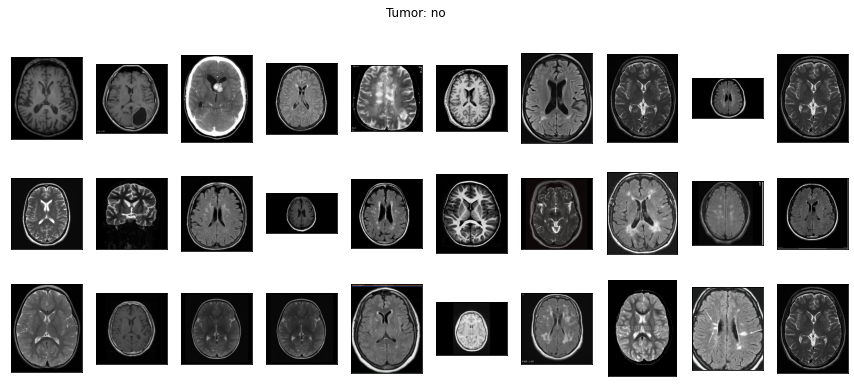

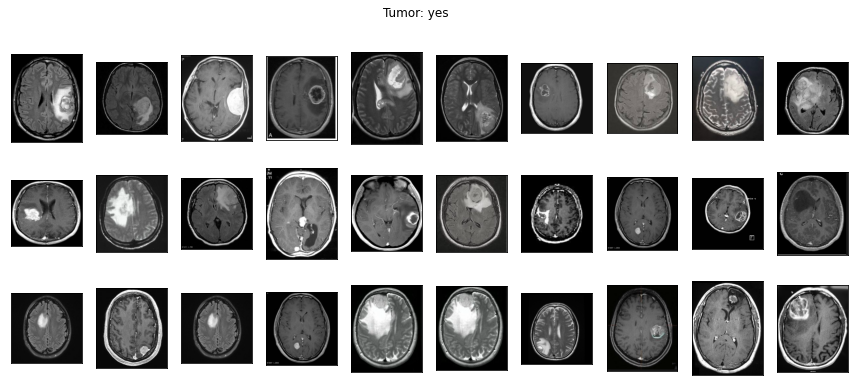

In [53]:
plot_samples(X_train, y_train, labels, 30)

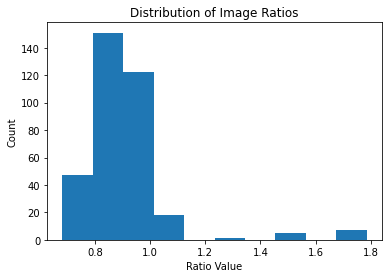

In [54]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [55]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [56]:
img = cv2.imread('/content/brain_tumor_dataset/yes/Y1.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

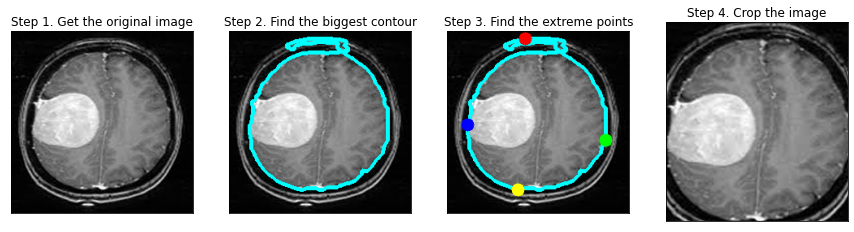

In [57]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [58]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



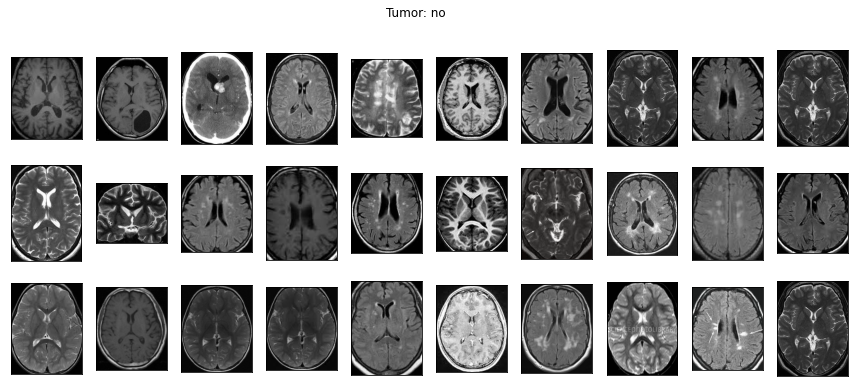

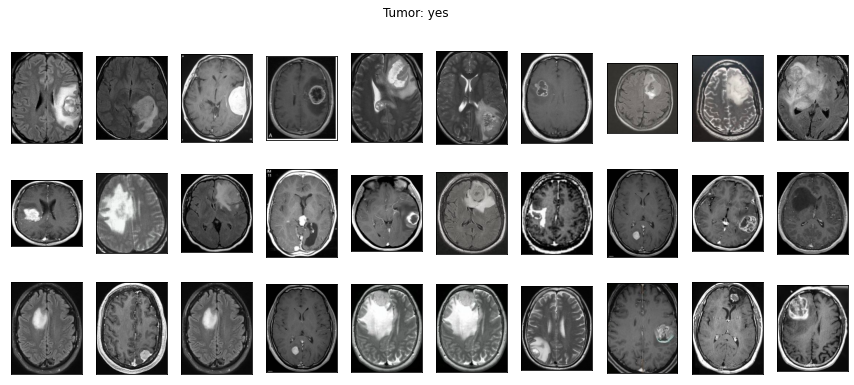

In [59]:
plot_samples(X_train_crop, y_train, labels, 30)

In [60]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [61]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO


save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [62]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [63]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [64]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [65]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

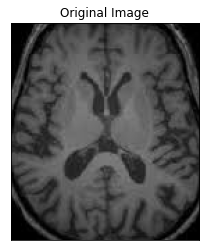

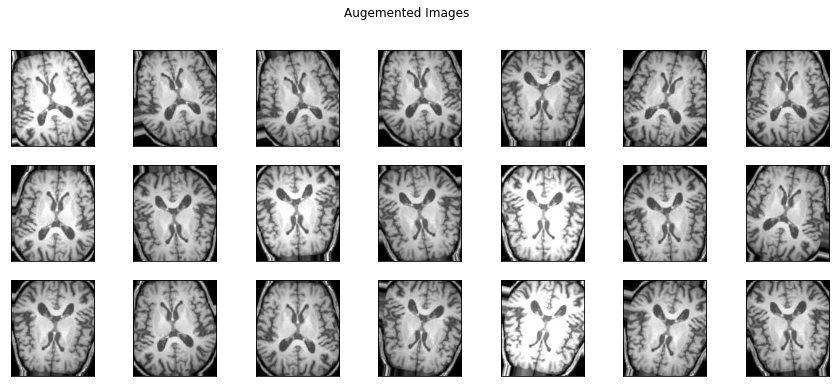

In [66]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [67]:
!rm -rf preview/

In [68]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 155 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [69]:
# load base model
vgg16_weight_path = '/content/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [70]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [75]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
50/50 [==============================] - 129s 2s/step - loss: 5.2111 - accuracy: 0.5548 - val_loss: 2.7571 - val_accuracy: 0.7041


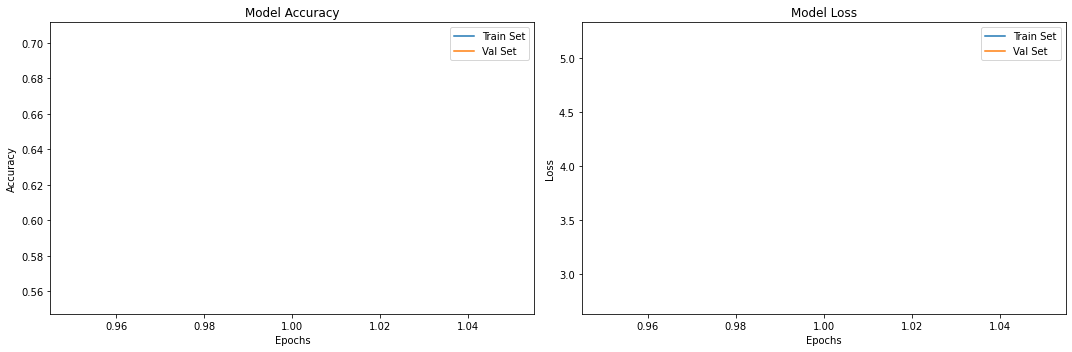

In [80]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.69


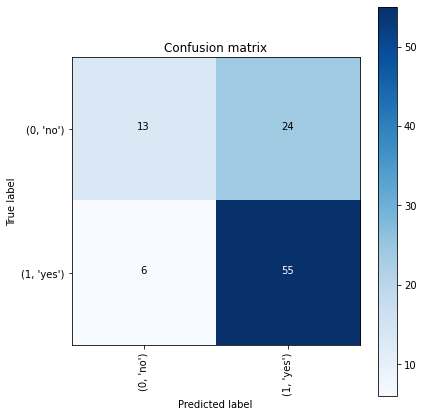

In [81]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.68


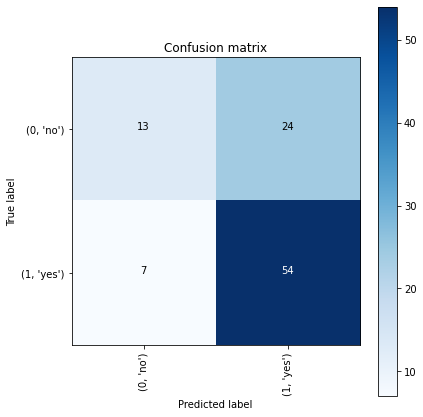

In [74]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [85]:
!zip -r /content/TEST_CROP.zip /content/TEST_CROP

  adding: content/TEST_CROP/ (stored 0%)
  adding: content/TEST_CROP/NO/ (stored 0%)
  adding: content/TEST_CROP/NO/35.jpg (deflated 2%)
  adding: content/TEST_CROP/NO/21.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/3.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/31.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/17.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/27.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/24.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/12.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/11.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/9.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/22.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/5.jpg (deflated 2%)
  adding: content/TEST_CROP/NO/2.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/25.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/26.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/30.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/20.jpg (deflated 1%)
  adding: content/TEST_CROP/NO/34.j

In [87]:
!zip -r /content/TRAIN_CROP.zip /content/TRAIN_CROP

  adding: content/TRAIN_CROP/ (stored 0%)
  adding: content/TRAIN_CROP/NO/ (stored 0%)
  adding: content/TRAIN_CROP/NO/35.jpg (deflated 1%)
  adding: content/TRAIN_CROP/NO/51.jpg (deflated 2%)
  adding: content/TRAIN_CROP/NO/21.jpg (deflated 1%)
  adding: content/TRAIN_CROP/NO/3.jpg (deflated 0%)
  adding: content/TRAIN_CROP/NO/31.jpg (deflated 1%)
  adding: content/TRAIN_CROP/NO/17.jpg (deflated 8%)
  adding: content/TRAIN_CROP/NO/27.jpg (deflated 1%)
  adding: content/TRAIN_CROP/NO/57.jpg (deflated 1%)
  adding: content/TRAIN_CROP/NO/24.jpg (deflated 2%)
  adding: content/TRAIN_CROP/NO/39.jpg (deflated 2%)
  adding: content/TRAIN_CROP/NO/44.jpg (deflated 2%)
  adding: content/TRAIN_CROP/NO/47.jpg (deflated 1%)
  adding: content/TRAIN_CROP/NO/12.jpg (deflated 2%)
  adding: content/TRAIN_CROP/NO/48.jpg (deflated 1%)
  adding: content/TRAIN_CROP/NO/45.jpg (deflated 1%)
  adding: content/TRAIN_CROP/NO/11.jpg (deflated 2%)
  adding: content/TRAIN_CROP/NO/49.jpg (deflated 1%)
  adding: con

In [88]:
!zip -r /content/VAL_CROP.zip /content/VAL_CROP

  adding: content/VAL_CROP/ (stored 0%)
  adding: content/VAL_CROP/NO/ (stored 0%)
  adding: content/VAL_CROP/NO/35.jpg (deflated 2%)
  adding: content/VAL_CROP/NO/21.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/3.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/31.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/17.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/27.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/24.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/12.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/11.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/9.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/22.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/5.jpg (deflated 2%)
  adding: content/VAL_CROP/NO/2.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/25.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/26.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/30.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/20.jpg (deflated 1%)
  adding: content/VAL_CROP/NO/34.jpg (deflated 2%)
  a